<a id="dataset"></a>
# Dataset preparation

In [1]:
#Initializing all the libraries
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('display.max_columns', 50)


C:\Users\advai\AppData\Local\Temp\ipykernel_15520\1852555527.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
!nvidia-smi

Tue May  7 20:04:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              3W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


In [4]:
import torch

torch.__version__

'2.2.2'

In [5]:
#Steps to install detectron2
# !pip uninstall --yes typing
# !pip install click==7.1.2

# !pip install detectron2 -f \
#   https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html

<a id="train_method"></a>
# Training method implementations

Basically we don't need to implement neural network part, `detectron2` already implements famous architectures and provides its pre-trained weights. We can finetune these pre-trained architectures.

We have chosen <b>R50-FPN</b> for this kernel.

## Data preparation

Returns a list of dictionaries, where each dictionary represents an image and its annotations in a format compatible with Detectron2.

In [6]:
import pickle
from pathlib import Path
from typing import Optional

import cv2
import numpy as np
import pandas as pd
from detectron2.structures import BoxMode
from tqdm import tqdm


def get_data_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
    use_class14: bool = False,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    class14_str = f"_14class{int(use_class14)}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{class14_str}{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv(imgdir / "train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str(imgdir / "train" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str(imgdir / "train" / f"{image_id}.png")
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    if use_class14:
                        # Use this No finding class with the bbox covering all image area.
                        bbox_resized = [0, 0, resized_width, resized_height]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    else:
                        # This annotator does not find anything, skip.
                        pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        float(row["x_min"]) * w_ratio,
                        float(row["y_min"]) * h_ratio,
                        float(row["x_max"]) * w_ratio,
                        float(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts


def get_data_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str(imgdir / "test" / f"{image_id}.png")
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


Functionality to store and load yaml file

In [7]:
# --- utils ---
from pathlib import Path
from typing import Any, Union

import yaml


def save_yaml(filepath: Union[str, Path], content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath: Union[str, Path]) -> Any:
    with open(filepath, "r") as f:
        content = yaml.full_load(f)
    return content


Defining all the class labels

In [8]:
# --- configs ---
thing_classes = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis"
]
category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}

<a id="mapper"></a>
### Mapper for augmentation

`Mapper` class is used inside pytorch `DataLoader`. It is responsible for converting `dataset_dicts` into actual data fed into the neural network, and we can insert augmentation process in this Mapper class.

In [9]:
import copy
import logging

import detectron2.data.transforms as T
import torch
from detectron2.data import detection_utils as utils


class MyMapper:
    """Mapper which uses `detectron2.data.transforms` augmentations"""

    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = []
        if is_train:
            aug_list.extend([getattr(T, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [10]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""
import albumentations as A
import copy
import numpy as np

import torch
from detectron2.data import detection_utils as utils


class AlbumentationsMapper:
    """Mapper which uses `albumentations` augmentations"""
    def __init__(self, cfg, is_train: bool = True):
        aug_kwargs = cfg.aug_kwargs
        aug_list = [
        ]
        if is_train:
            aug_list.extend([getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category_ids"])
        )
        self.is_train = is_train

        mode = "training" if is_train else "inference"
        print(f"[AlbumentationsMapper] Augmentations used in {mode}: {self.transform}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        # aug_input = T.AugInput(image)
        # transforms = self.augmentations(aug_input)
        # image = aug_input.image

        prev_anno = dataset_dict["annotations"]
        bboxes = np.array([obj["bbox"] for obj in prev_anno], dtype=np.float32)
        # category_id = np.array([obj["category_id"] for obj in dataset_dict["annotations"]], dtype=np.int64)
        category_id = np.arange(len(dataset_dict["annotations"]))

        transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_id)
        image = transformed["image"]
        annos = []
        for i, j in enumerate(transformed["category_ids"]):
            d = prev_anno[j]
            d["bbox"] = transformed["bboxes"][i]
            annos.append(d)
        dataset_dict.pop("annotations", None)  # Remove unnecessary field.

        # if not self.is_train:
        #     # USER: Modify this if you want to keep them for some reason.
        #     dataset_dict.pop("annotations", None)
        #     dataset_dict.pop("sem_seg_file_name", None)
        #     return dataset_dict

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

<a id="evaluator"></a>
## Evaluator

To evaluate validation dataset to calculate competition metric, we need `Evaluator`.

In [11]:
"""
Original code from https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py
Just modified to show AP@40
"""
# Copyright (c) Facebook, Inc. and its affiliates.
import contextlib
import copy
import io
import itertools
import json
import logging
import numpy as np
import os
import pickle
from collections import OrderedDict
import pycocotools.mask as mask_util
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from tabulate import tabulate

import detectron2.utils.comm as comm
from detectron2.config import CfgNode
from detectron2.data import MetadataCatalog
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.evaluation.fast_eval_api import COCOeval_opt
from detectron2.structures import Boxes, BoxMode, pairwise_iou
from detectron2.utils.file_io import PathManager
from detectron2.utils.logger import create_small_table


def data_summarize(self):
    '''
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    '''

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]
        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, :, aind, mind]
        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]
            s = s[:, :, aind, mind]
        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])
        print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s))
        return mean_s

    def _summarizeDets():
        stats = np.zeros((12,))
        stats[0] = _summarize(1)
        stats[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
        # stats[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
        stats[2] = _summarize(1, iouThr=.4, maxDets=self.params.maxDets[2])
        stats[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
        stats[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
        stats[6] = _summarize(0, maxDets=self.params.maxDets[0])
        stats[7] = _summarize(0, maxDets=self.params.maxDets[1])
        stats[8] = _summarize(0, maxDets=self.params.maxDets[2])
        stats[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
        stats[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
        stats[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])
        return stats

    def _summarizeKps():
        stats = np.zeros((10,))
        stats[0] = _summarize(1, maxDets=20)
        stats[1] = _summarize(1, maxDets=20, iouThr=.5)
        stats[2] = _summarize(1, maxDets=20, iouThr=.75)
        stats[3] = _summarize(1, maxDets=20, areaRng='medium')
        stats[4] = _summarize(1, maxDets=20, areaRng='large')
        stats[5] = _summarize(0, maxDets=20)
        stats[6] = _summarize(0, maxDets=20, iouThr=.5)
        stats[7] = _summarize(0, maxDets=20, iouThr=.75)
        stats[8] = _summarize(0, maxDets=20, areaRng='medium')
        stats[9] = _summarize(0, maxDets=20, areaRng='large')
        return stats

    if not self.eval:
        raise Exception('Please run accumulate() first')
    iouType = self.params.iouType
    if iouType == 'segm' or iouType == 'bbox':
        summarize = _summarizeDets
    elif iouType == 'keypoints':
        summarize = _summarizeKps
    self.stats = summarize()


print("HACKING: overriding COCOeval.summarize = data_summarize...")
COCOeval.summarize = data_summarize


class DataEvaluator(DatasetEvaluator):
    """
    Evaluate AR for object proposals, AP for instance detection/segmentation, AP
    for keypoint detection outputs using COCO's metrics.
    See http://cocodataset.org/#detection-eval and
    http://cocodataset.org/#keypoints-eval to understand its metrics.

    In addition to COCO, this evaluator is able to support any bounding box detection,
    instance segmentation, or keypoint detection dataset.
    """

    def __init__(
        self,
        dataset_name,
        tasks=None,
        distributed=True,
        output_dir=None,
        *,
        use_fast_impl=True,
        kpt_oks_sigmas=(),
    ):
        """
        Args:
            dataset_name (str): name of the dataset to be evaluated.
                It must have either the following corresponding metadata:

                    "json_file": the path to the COCO format annotation

                Or it must be in detectron2's standard dataset format
                so it can be converted to COCO format automatically.
            tasks (tuple[str]): tasks that can be evaluated under the given
                configuration. A task is one of "bbox", "segm", "keypoints".
                By default, will infer this automatically from predictions.
            distributed (True): if True, will collect results from all ranks and run evaluation
                in the main process.
                Otherwise, will only evaluate the results in the current process.
            output_dir (str): optional, an output directory to dump all
                results predicted on the dataset. The dump contains two files:

                1. "instances_predictions.pth" a file in torch serialization
                   format that contains all the raw original predictions.
                2. "coco_instances_results.json" a json file in COCO's result
                   format.
            use_fast_impl (bool): use a fast but **unofficial** implementation to compute AP.
                Although the results should be very close to the official implementation in COCO
                API, it is still recommended to compute results with the official API for use in
                papers. The faster implementation also uses more RAM.
            kpt_oks_sigmas (list[float]): The sigmas used to calculate keypoint OKS.
                See http://cocodataset.org/#keypoints-eval
                When empty, it will use the defaults in COCO.
                Otherwise it should be the same length as ROI_KEYPOINT_HEAD.NUM_KEYPOINTS.
        """
        self._logger = logging.getLogger(__name__)
        self._distributed = distributed
        self._output_dir = output_dir
        self._use_fast_impl = use_fast_impl

        if tasks is not None and isinstance(tasks, CfgNode):
            kpt_oks_sigmas = (
                tasks.TEST.KEYPOINT_OKS_SIGMAS if not kpt_oks_sigmas else kpt_oks_sigmas
            )
            self._logger.warn(
                "COCO Evaluator instantiated using config, this is deprecated behavior."
                " Please pass in explicit arguments instead."
            )
            self._tasks = None  # Infering it from predictions should be better
        else:
            self._tasks = tasks

        self._cpu_device = torch.device("cpu")

        self._metadata = MetadataCatalog.get(dataset_name)
        if not hasattr(self._metadata, "json_file"):
            self._logger.info(
                f"'{dataset_name}' is not registered by `register_coco_instances`."
                " Therefore trying to convert it to COCO format ..."
            )

            cache_path = os.path.join(output_dir, f"{dataset_name}_coco_format.json")
            self._metadata.json_file = cache_path
            convert_to_coco_json(dataset_name, cache_path)

        json_file = PathManager.get_local_path(self._metadata.json_file)
        with contextlib.redirect_stdout(io.StringIO()):
            self._coco_api = COCO(json_file)

        # Test set json files do not contain annotations (evaluation must be
        # performed using the COCO evaluation server).
        self._do_evaluation = "annotations" in self._coco_api.dataset
        if self._do_evaluation:
            self._kpt_oks_sigmas = kpt_oks_sigmas

    def reset(self):
        self._predictions = []

    def process(self, inputs, outputs):
        """
        Args:
            inputs: the inputs to a COCO model (e.g., GeneralizedRCNN).
                It is a list of dict. Each dict corresponds to an image and
                contains keys like "height", "width", "file_name", "image_id".
            outputs: the outputs of a COCO model. It is a list of dicts with key
                "instances" that contains :class:`Instances`.
        """
        for input, output in zip(inputs, outputs):
            prediction = {"image_id": input["image_id"]}

            if "instances" in output:
                instances = output["instances"].to(self._cpu_device)
                prediction["instances"] = instances_to_coco_json(instances, input["image_id"])
            if "proposals" in output:
                prediction["proposals"] = output["proposals"].to(self._cpu_device)
            if len(prediction) > 1:
                self._predictions.append(prediction)

    def evaluate(self, img_ids=None):
        """
        Args:
            img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
        """
        if self._distributed:
            comm.synchronize()
            predictions = comm.gather(self._predictions, dst=0)
            predictions = list(itertools.chain(*predictions))

            if not comm.is_main_process():
                return {}
        else:
            predictions = self._predictions

        if len(predictions) == 0:
            self._logger.warning("[DataEvaluator] Did not receive valid predictions.")
            return {}

        if self._output_dir:
            PathManager.mkdirs(self._output_dir)
            file_path = os.path.join(self._output_dir, "instances_predictions.pth")
            with PathManager.open(file_path, "wb") as f:
                torch.save(predictions, f)

        self._results = OrderedDict()
        if "proposals" in predictions[0]:
            self._eval_box_proposals(predictions)
        if "instances" in predictions[0]:
            self._eval_predictions(predictions, img_ids=img_ids)
        # Copy so the caller can do whatever with results
        return copy.deepcopy(self._results)

    def _tasks_from_predictions(self, predictions):
        """
        Get COCO API "tasks" (i.e. iou_type) from COCO-format predictions.
        """
        tasks = {"bbox"}
        for pred in predictions:
            if "segmentation" in pred:
                tasks.add("segm")
            if "keypoints" in pred:
                tasks.add("keypoints")
        return sorted(tasks)

    def _eval_predictions(self, predictions, img_ids=None):
        """
        Evaluate predictions. Fill self._results with the metrics of the tasks.
        """
        self._logger.info("Preparing results for COCO format ...")
        coco_results = list(itertools.chain(*[x["instances"] for x in predictions]))
        tasks = self._tasks or self._tasks_from_predictions(coco_results)

        # unmap the category ids for COCO
        if hasattr(self._metadata, "thing_dataset_id_to_contiguous_id"):
            dataset_id_to_contiguous_id = self._metadata.thing_dataset_id_to_contiguous_id
            all_contiguous_ids = list(dataset_id_to_contiguous_id.values())
            num_classes = len(all_contiguous_ids)
            assert min(all_contiguous_ids) == 0 and max(all_contiguous_ids) == num_classes - 1

            reverse_id_mapping = {v: k for k, v in dataset_id_to_contiguous_id.items()}
            for result in coco_results:
                category_id = result["category_id"]
                assert category_id < num_classes, (
                    f"A prediction has class={category_id}, "
                    f"but the dataset only has {num_classes} classes and "
                    f"predicted class id should be in [0, {num_classes - 1}]."
                )
                result["category_id"] = reverse_id_mapping[category_id]

        if self._output_dir:
            file_path = os.path.join(self._output_dir, "coco_instances_results.json")
            self._logger.info("Saving results to {}".format(file_path))
            with PathManager.open(file_path, "w") as f:
                f.write(json.dumps(coco_results))
                f.flush()

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info(
            "Evaluating predictions with {} COCO API...".format(
                "unofficial" if self._use_fast_impl else "official"
            )
        )
        for task in sorted(tasks):
            coco_eval = (
                _evaluate_predictions_on_coco(
                    self._coco_api,
                    coco_results,
                    task,
                    kpt_oks_sigmas=self._kpt_oks_sigmas,
                    use_fast_impl=self._use_fast_impl,
                    img_ids=img_ids,
                )
                if len(coco_results) > 0
                else None  # cocoapi does not handle empty results very well
            )

            res = self._derive_coco_results(
                coco_eval, task, class_names=self._metadata.get("thing_classes")
            )
            self._results[task] = res

    def _eval_box_proposals(self, predictions):
        """
        Evaluate the box proposals in predictions.
        Fill self._results with the metrics for "box_proposals" task.
        """
        if self._output_dir:
            # Saving generated box proposals to file.
            # Predicted box_proposals are in XYXY_ABS mode.
            bbox_mode = BoxMode.XYXY_ABS.value
            ids, boxes, objectness_logits = [], [], []
            for prediction in predictions:
                ids.append(prediction["image_id"])
                boxes.append(prediction["proposals"].proposal_boxes.tensor.numpy())
                objectness_logits.append(prediction["proposals"].objectness_logits.numpy())

            proposal_data = {
                "boxes": boxes,
                "objectness_logits": objectness_logits,
                "ids": ids,
                "bbox_mode": bbox_mode,
            }
            with PathManager.open(os.path.join(self._output_dir, "box_proposals.pkl"), "wb") as f:
                pickle.dump(proposal_data, f)

        if not self._do_evaluation:
            self._logger.info("Annotations are not available for evaluation.")
            return

        self._logger.info("Evaluating bbox proposals ...")
        res = {}
        areas = {"all": "", "small": "s", "medium": "m", "large": "l"}
        for limit in [100, 1000]:
            for area, suffix in areas.items():
                stats = _evaluate_box_proposals(predictions, self._coco_api, area=area, limit=limit)
                key = "AR{}@{:d}".format(suffix, limit)
                res[key] = float(stats["ar"].item() * 100)
        self._logger.info("Proposal metrics: \n" + create_small_table(res))
        self._results["box_proposals"] = res

    def _derive_coco_results(self, coco_eval, iou_type, class_names=None):
        """
        Derive the desired score numbers from summarized COCOeval.

        Args:
            coco_eval (None or COCOEval): None represents no predictions from model.
            iou_type (str):
            class_names (None or list[str]): if provided, will use it to predict
                per-category AP.

        Returns:
            a dict of {metric name: score}
        """

        metrics = {
            "bbox": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "segm": ["AP", "AP50", "AP75", "APs", "APm", "APl"],
            "keypoints": ["AP", "AP50", "AP75", "APm", "APl"],
        }[iou_type]

        if coco_eval is None:
            self._logger.warn("No predictions from the model!")
            return {metric: float("nan") for metric in metrics}

        # the standard metrics
        results = {
            metric: float(coco_eval.stats[idx] * 100 if coco_eval.stats[idx] >= 0 else "nan")
            for idx, metric in enumerate(metrics)
        }
        self._logger.info(
            "Evaluation results for {}: \n".format(iou_type) + create_small_table(results)
        )
        if not np.isfinite(sum(results.values())):
            self._logger.info("Some metrics cannot be computed and is shown as NaN.")

        if class_names is None or len(class_names) <= 1:
            return results
        # Compute per-category AP
        # from https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L222-L252 # noqa
        precisions = coco_eval.eval["precision"]
        # precision has dims (iou, recall, cls, area range, max dets)
        assert len(class_names) == precisions.shape[2]

        results_per_category = []
        for idx, name in enumerate(class_names):
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            precision = precisions[:, :, idx, 0, -1]
            precision = precision[precision > -1]
            ap = np.mean(precision) if precision.size else float("nan")
            results_per_category.append(("{}".format(name), float(ap * 100)))

        # tabulate it
        N_COLS = min(6, len(results_per_category) * 2)
        results_flatten = list(itertools.chain(*results_per_category))
        results_2d = itertools.zip_longest(*[results_flatten[i::N_COLS] for i in range(N_COLS)])
        table = tabulate(
            results_2d,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=["category", "AP"] * (N_COLS // 2),
            numalign="left",
        )
        self._logger.info("Per-category {} AP: \n".format(iou_type) + table)

        results.update({"AP-" + name: ap for name, ap in results_per_category})
        return results


def instances_to_coco_json(instances, img_id):
    """
    Dump an "Instances" object to a COCO-format json that's used for evaluation.

    Args:
        instances (Instances):
        img_id (int): the image id

    Returns:
        list[dict]: list of json annotations in COCO format.
    """
    num_instance = len(instances)
    if num_instance == 0:
        return []

    boxes = instances.pred_boxes.tensor.numpy()
    boxes = BoxMode.convert(boxes, BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    boxes = boxes.tolist()
    scores = instances.scores.tolist()
    classes = instances.pred_classes.tolist()

    has_mask = instances.has("pred_masks")
    if has_mask:
        # use RLE to encode the masks, because they are too large and takes memory
        # since this evaluator stores outputs of the entire dataset
        rles = [
            mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
            for mask in instances.pred_masks
        ]
        for rle in rles:
            # "counts" is an array encoded by mask_util as a byte-stream. Python3's
            # json writer which always produces strings cannot serialize a bytestream
            # unless you decode it. Thankfully, utf-8 works out (which is also what
            # the pycocotools/_mask.pyx does).
            rle["counts"] = rle["counts"].decode("utf-8")

    has_keypoints = instances.has("pred_keypoints")
    if has_keypoints:
        keypoints = instances.pred_keypoints

    results = []
    for k in range(num_instance):
        result = {
            "image_id": img_id,
            "category_id": classes[k],
            "bbox": boxes[k],
            "score": scores[k],
        }
        if has_mask:
            result["segmentation"] = rles[k]
        if has_keypoints:
            # In COCO annotations,
            # keypoints coordinates are pixel indices.
            # However our predictions are floating point coordinates.
            # Therefore we subtract 0.5 to be consistent with the annotation format.
            # This is the inverse of data loading logic in `datasets/coco.py`.
            keypoints[k][:, :2] -= 0.5
            result["keypoints"] = keypoints[k].flatten().tolist()
        results.append(result)
    return results


# inspired from Detectron:
# https://github.com/facebookresearch/Detectron/blob/a6a835f5b8208c45d0dce217ce9bbda915f44df7/detectron/datasets/json_dataset_evaluator.py#L255 # noqa
def _evaluate_box_proposals(dataset_predictions, coco_api, thresholds=None, area="all", limit=None):
    """
    Evaluate detection proposal recall metrics. This function is a much
    faster alternative to the official COCO API recall evaluation code. However,
    it produces slightly different results.
    """
    # Record max overlap value for each gt box
    # Return vector of overlap values
    areas = {
        "all": 0,
        "small": 1,
        "medium": 2,
        "large": 3,
        "96-128": 4,
        "128-256": 5,
        "256-512": 6,
        "512-inf": 7,
    }
    area_ranges = [
        [0 ** 2, 1e5 ** 2],  # all
        [0 ** 2, 32 ** 2],  # small
        [32 ** 2, 96 ** 2],  # medium
        [96 ** 2, 1e5 ** 2],  # large
        [96 ** 2, 128 ** 2],  # 96-128
        [128 ** 2, 256 ** 2],  # 128-256
        [256 ** 2, 512 ** 2],  # 256-512
        [512 ** 2, 1e5 ** 2],
    ]  # 512-inf
    assert area in areas, "Unknown area range: {}".format(area)
    area_range = area_ranges[areas[area]]
    gt_overlaps = []
    num_pos = 0

    for prediction_dict in dataset_predictions:
        predictions = prediction_dict["proposals"]

        # sort predictions in descending order
        # TODO maybe remove this and make it explicit in the documentation
        inds = predictions.objectness_logits.sort(descending=True)[1]
        predictions = predictions[inds]

        ann_ids = coco_api.getAnnIds(imgIds=prediction_dict["image_id"])
        anno = coco_api.loadAnns(ann_ids)
        gt_boxes = [
            BoxMode.convert(obj["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            for obj in anno
            if obj["iscrowd"] == 0
        ]
        gt_boxes = torch.as_tensor(gt_boxes).reshape(-1, 4)  # guard against no boxes
        gt_boxes = Boxes(gt_boxes)
        gt_areas = torch.as_tensor([obj["area"] for obj in anno if obj["iscrowd"] == 0])

        if len(gt_boxes) == 0 or len(predictions) == 0:
            continue

        valid_gt_inds = (gt_areas >= area_range[0]) & (gt_areas <= area_range[1])
        gt_boxes = gt_boxes[valid_gt_inds]

        num_pos += len(gt_boxes)

        if len(gt_boxes) == 0:
            continue

        if limit is not None and len(predictions) > limit:
            predictions = predictions[:limit]

        overlaps = pairwise_iou(predictions.proposal_boxes, gt_boxes)

        _gt_overlaps = torch.zeros(len(gt_boxes))
        for j in range(min(len(predictions), len(gt_boxes))):
            # find which proposal box maximally covers each gt box
            # and get the iou amount of coverage for each gt box
            max_overlaps, argmax_overlaps = overlaps.max(dim=0)

            # find which gt box is 'best' covered (i.e. 'best' = most iou)
            gt_ovr, gt_ind = max_overlaps.max(dim=0)
            assert gt_ovr >= 0
            # find the proposal box that covers the best covered gt box
            box_ind = argmax_overlaps[gt_ind]
            # record the iou coverage of this gt box
            _gt_overlaps[j] = overlaps[box_ind, gt_ind]
            assert _gt_overlaps[j] == gt_ovr
            # mark the proposal box and the gt box as used
            overlaps[box_ind, :] = -1
            overlaps[:, gt_ind] = -1

        # append recorded iou coverage level
        gt_overlaps.append(_gt_overlaps)
    gt_overlaps = (
        torch.cat(gt_overlaps, dim=0) if len(gt_overlaps) else torch.zeros(0, dtype=torch.float32)
    )
    gt_overlaps, _ = torch.sort(gt_overlaps)

    if thresholds is None:
        step = 0.05
        # thresholds = torch.arange(0.5, 0.95 + 1e-5, step, dtype=torch.float32)
        thresholds = torch.arange(0.4, 0.95 + 1e-5, step, dtype=torch.float32)
    recalls = torch.zeros_like(thresholds)
    # compute recall for each iou threshold
    for i, t in enumerate(thresholds):
        recalls[i] = (gt_overlaps >= t).float().sum() / float(num_pos)
    # ar = 2 * np.trapz(recalls, thresholds)
    ar = recalls.mean()
    return {
        "ar": ar,
        "recalls": recalls,
        "thresholds": thresholds,
        "gt_overlaps": gt_overlaps,
        "num_pos": num_pos,
    }


def _evaluate_predictions_on_coco(
    coco_gt, coco_results, iou_type, kpt_oks_sigmas=None, use_fast_impl=True, img_ids=None
):
    """
    Evaluate the coco results using COCOEval API.
    """
    assert len(coco_results) > 0

    if iou_type == "segm":
        coco_results = copy.deepcopy(coco_results)
        # When evaluating mask AP, if the results contain bbox, cocoapi will
        # use the box area as the area of the instance, instead of the mask area.
        # This leads to a different definition of small/medium/large.
        # We remove the bbox field to let mask AP use mask area.
        for c in coco_results:
            c.pop("bbox", None)

    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = (COCOeval_opt if use_fast_impl else COCOeval)(coco_gt, coco_dt, iou_type)

    # HACKING: overwrite iouThrs to calc ious 0.4
    coco_eval.params.iouThrs = np.linspace(
        .4, 0.95, int(np.round((0.95 - .4) / .05)) + 1, endpoint=True)

    if img_ids is not None:
        coco_eval.params.imgIds = img_ids

    if iou_type == "keypoints":
        # Use the COCO default keypoint OKS sigmas unless overrides are specified
        if kpt_oks_sigmas:
            assert hasattr(coco_eval.params, "kpt_oks_sigmas"), "pycocotools is too old!"
            coco_eval.params.kpt_oks_sigmas = np.array(kpt_oks_sigmas)
        # COCOAPI requires every detection and every gt to have keypoints, so
        # we just take the first entry from both
        num_keypoints_dt = len(coco_results[0]["keypoints"]) // 3
        num_keypoints_gt = len(next(iter(coco_gt.anns.values()))["keypoints"]) // 3
        num_keypoints_oks = len(coco_eval.params.kpt_oks_sigmas)
        assert num_keypoints_oks == num_keypoints_dt == num_keypoints_gt, (
            f"[DataEvaluator] Prediction contain {num_keypoints_dt} keypoints. "
            f"Ground truth contains {num_keypoints_gt} keypoints. "
            f"The length of cfg.TEST.KEYPOINT_OKS_SIGMAS is {num_keypoints_oks}. "
            "They have to agree with each other. For meaning of OKS, please refer to "
            "http://cocodataset.org/#keypoints-eval."
        )

    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval

HACKING: overriding COCOeval.summarize = data_summarize...


In [12]:
"""
To calculate & record validation loss

Original code from https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
by @apofeniaco
"""
import numpy as np
import logging

from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
import detectron2.utils.comm as comm
import torch
import time
import datetime


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        # self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        # return losses
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = int(self.trainer.iter) + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            self.trainer.storage.put_scalars(validation_loss=mean_loss)
            print("validation do loss eval", mean_loss)
        else:
            pass
            # self.trainer.storage.put_scalars(timetest=11)


In [13]:
import os

from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch

# from detectron2.evaluation import COCOEvaluator, PascalVOCDetectionEvaluator


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=AlbumentationsMapper(cfg, True), sampler=sampler
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(
            cfg, dataset_name, mapper=AlbumentationsMapper(cfg, False)
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        # return PascalVOCDetectionEvaluator(dataset_name)  # not working
        # return COCOEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)
        return DataEvaluator(dataset_name, ("bbox",), False, output_dir=output_folder)

    def build_hooks(self):
        hooks = super(MyTrainer, self).build_hooks()
        cfg = self.cfg
        if len(cfg.DATASETS.TEST) > 0:
            loss_eval_hook = LossEvalHook(
                cfg.TEST.EVAL_PERIOD,
                self.model,
                MyTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0]),
            )
            hooks.insert(-1, loss_eval_hook)

        return hooks


<a id="load_data"></a>
# Loading Data

In [14]:
import argparse
import dataclasses
import json
import os
import pickle
import random
import sys
from dataclasses import dataclass
from distutils.util import strtobool
from pathlib import Path

import cv2
import detectron2
import numpy as np
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm

setup_logger()

<Logger detectron2 (DEBUG)>

In [15]:
# --- flags ---
from dataclasses import dataclass, field
from typing import Dict


@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"

    # Data config
    imgdir_name: str = "data-resized-256x256"
    split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    train_data_type: str = "original"  # original or wbf
    use_class14: bool = False
    # Training config
    iter: int = 10000
    ims_per_batch: int = 2  # images per batch, this corresponds to "total batch size"
    num_workers: int = 4
    lr_scheduler_name: str = "WarmupMultiStepLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    aug_kwargs: Dict = field(default_factory=lambda: {})

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [16]:
flags_dict = {
    "debug": False,
    "outdir": "results", 
    "imgdir_name": "data-resized-256x256",
    "split_mode": "valid20",
    "iter": 10000,
    "roi_batch_size_per_image": 512,
    "eval_period": 1000,
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.001,
    "num_workers": 4,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5}
    }
}

In [17]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

# --- Read data ---
inputdir = Path("input")
datadir = inputdir / "data-dicom-format"
imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
print(datadir)
train_df = pd.read_csv(datadir / "train.csv")
train = train_df  # alias
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

torch 2.2.2
flags Flags(debug=False, outdir='results', imgdir_name='data-resized-256x256', split_mode='valid20', seed=111, train_data_type='original', use_class14=False, iter=10000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=512, eval_period=1000, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}})
input\data-dicom-format


In [18]:
train_data_type = flags.train_data_type
if flags.use_class14:
    thing_classes.append("No finding")

split_mode = flags.split_mode
if split_mode == "all_train":
    DatasetCatalog.register(
        "data_train",
        lambda: get_data_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        ),
    )
    MetadataCatalog.get("data_train").set(thing_classes=thing_classes)
elif split_mode == "valid20":
    # To get number of data...
    n_dataset = len(
        get_data_dicts(
            imgdir, train_df, train_data_type, debug=debug, use_class14=flags.use_class14
        )
    )
    n_train = int(n_dataset * 0.8)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(flags.seed)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        "data_train",
        lambda: get_data_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=train_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("data_train").set(thing_classes=thing_classes)
    DatasetCatalog.register(
        "data_valid",
        lambda: get_data_dicts(
            imgdir,
            train_df,
            train_data_type,
            debug=debug,
            target_indices=valid_inds,
            use_class14=flags.use_class14,
        ),
    )
    MetadataCatalog.get("data_valid").set(thing_classes=thing_classes)
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")


Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
n_dataset 15000 n_train 12000


In [19]:
dataset_dicts = get_data_dicts(imgdir, train, debug=debug)

Load from cache dataset_dicts_cache_original_14class0_debug0.pkl


In [20]:
# dataset_dicts

In [21]:
len(dataset_dicts)

15000

['ARXIV_V5_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'Data_Entry_2017.csv', 'FAQ_CHESTXRAY.pdf', 'images', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'test_list.txt', 'train_val_list.txt']
(112120, 12)
(984, 9)
(984, 9)


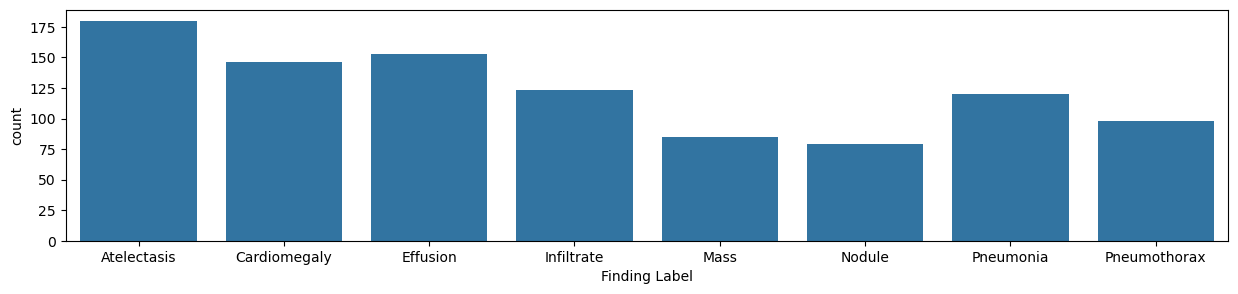

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from glob import glob
import os
print(os.listdir("input/data"))

# Any results you write to the current directory are saved as output.

df_data = pd.read_csv('input/data/Data_Entry_2017.csv')
df_annotations = pd.read_csv('input/data/BBox_List_2017.csv')

print(df_data.shape)
print(df_annotations.shape)
df_data.head()

print(df_annotations.shape)
df_annotations.drop(['Unnamed: 6','Unnamed: 7','Unnamed: 8'], axis = 1, inplace= True)
#df_annotations.head()

new_df = pd.merge(df_annotations, df_data , on= 'Image Index')
#new_df.shape

import seaborn as sns

plt.figure(figsize=(15, 3))
sns.countplot(x='Finding Label', data=new_df)
plt.show()

In [23]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('input/data', 'images/images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', new_df.shape[0])
new_df['path'] = new_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
new_df.sample(3)
#new_df.columns

new_df2 = new_df[['path','Patient ID','Finding Label','Bbox [x', 'y', 'w', 'h]']]

new_df2.rename(columns={'Patient ID':'image_id', 
                        'Finding Label' : 'class_id',
                        'Bbox [x' : 'x_min',
                        'y' : 'y_min',
                        'w' : 'x_max',
                        'h]' : 'y_max'}, inplace=True)

new_df3 = new_df2.copy()

for i in range(len(new_df3)):
    new_df3.loc[i, 'x_max'] = new_df3.loc[i, 'x_max'] + new_df3.loc[i, 'x_min']
    new_df3.loc[i, 'y_max'] = new_df3.loc[i, 'y_max'] + new_df3.loc[i, 'y_min']


Scans found: 112120 , Total Headers 984


In [24]:
import cv2
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    return img

from tqdm import tqdm 
train_img = []
for img_path in tqdm(new_df3['path'].values):
    train_img.append(read_img(img_path))

100%|██████████| 984/984 [00:13<00:00, 74.33it/s]


In [25]:
X = np.array(train_img, np.float32) / 255  

IMAGE_SIZE = 256
new_df3['x_min'] = new_df3['x_min'] *  IMAGE_SIZE /1024 #new_df['OriginalImage[Width']
new_df3['y_min'] = new_df3['y_min'] *  IMAGE_SIZE / 1024 #new_df['Height]']
new_df3['x_max'] = new_df3['x_max'] *  IMAGE_SIZE /1024 #new_df['OriginalImage[Width']
new_df3['y_max'] = new_df3['y_max'] *  IMAGE_SIZE /1024 #new_df['Height]']

print(new_df3['x_min'][10])
print(new_df3['y_min'][10])
print(new_df3['x_max'][10])
print(new_df3['y_max'][10])

158.23728813559325
62.992092326536
215.18644067796623
115.60226181806149


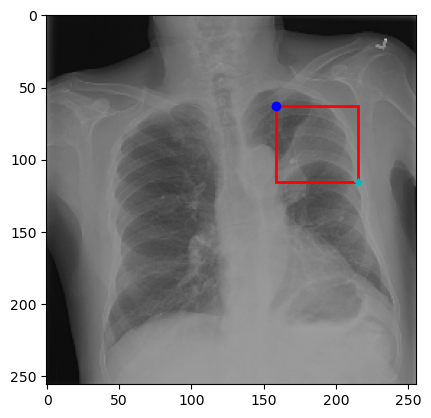

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

k=10
#img=train_images[k]
img = X[k]
x_min = new_df3['x_min'][k]
y_min = new_df3['y_min'][k]
x_max = new_df3['x_max'][k]
y_max = new_df3['y_max'][k]

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
# x1-x0 is the width of the bounding box
# y1-y0 is the height of the bounding box
rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.plot(x_min, y_min, 'o', color='b')  # top-left corner
ax.plot(x_max, y_max, '*', color='c' ) # bottom-right corner

plt.show()

## NIH label
- Atelectasis - 1
- Effusion - 10
- Mass,Nodule - 8
- Cardiomegaly - 3
- Infiltrate - 6
- Pneumothorax - 12


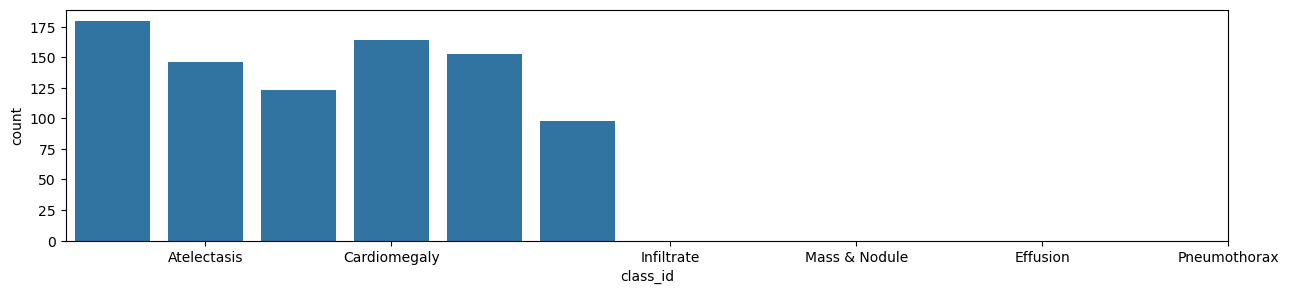

In [27]:
new_df4 = new_df3.copy()

for i in range(len(new_df4)):
    if new_df4.loc[i, 'class_id'] == 'Atelectasis':
        new_df4.loc[i, 'class_id'] = 1
    elif new_df4.loc[i, 'class_id'] == 'Effusion':
        new_df4.loc[i, 'class_id'] = 10
    elif new_df4.loc[i, 'class_id'] == 'Mass' or new_df4.loc[i, 'class_id'] == 'Nodule':
        new_df4.loc[i, 'class_id'] = 8
    elif new_df4.loc[i, 'class_id'] == 'Cardiomegaly':
        new_df4.loc[i, 'class_id'] = 3
    elif new_df4.loc[i, 'class_id'] == 'Infiltrate':
        new_df4.loc[i, 'class_id'] = 6
    elif new_df4.loc[i, 'class_id'] == 'Pneumothorax':
        new_df4.loc[i, 'class_id'] = 12
    else:
        new_df4.loc[i, 'class_id'] = None
        
new_df5 = new_df4.dropna()
new_df5.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15, 3))
sns.countplot(x='class_id', data=new_df5)
plt.xticks([1, 3, 6, 8, 10, 12], ['Atelectasis', 'Cardiomegaly', 'Infiltrate', 'Mass & Nodule', 'Effusion', 'Pneumothorax'])
plt.show()


In [28]:
dataset_dicts2 = []

for i in range(len(new_df5)):

    record = {}
    record["file_name"] = new_df5['path'][i]
    record["image_id"] = new_df5['image_id'][i]
    record["height"] = IMAGE_SIZE #256
    record["width"] = IMAGE_SIZE #256

    objs = []

    bbox_resized = [
        float(new_df5["x_min"][i]),
        float(new_df5["y_min"][i]),
        float(new_df5["x_max"][i]),
        float(new_df5["y_max"][i])
    ]

    obj = {
        "bbox": bbox_resized,
        "bbox_mode": BoxMode.XYXY_ABS,
        "category_id": new_df5['class_id'][i]
    }

    objs.append(obj)
    record["annotations"] = objs

    dataset_dicts2.append(record)

In [29]:
#print(dataset_dicts2)
dataset_dicts = dataset_dicts + dataset_dicts2

<a id="data_vis"></a>
# Data Visualization

It's very easy to visualize prepared training dataset with `detectron2`.<br/>

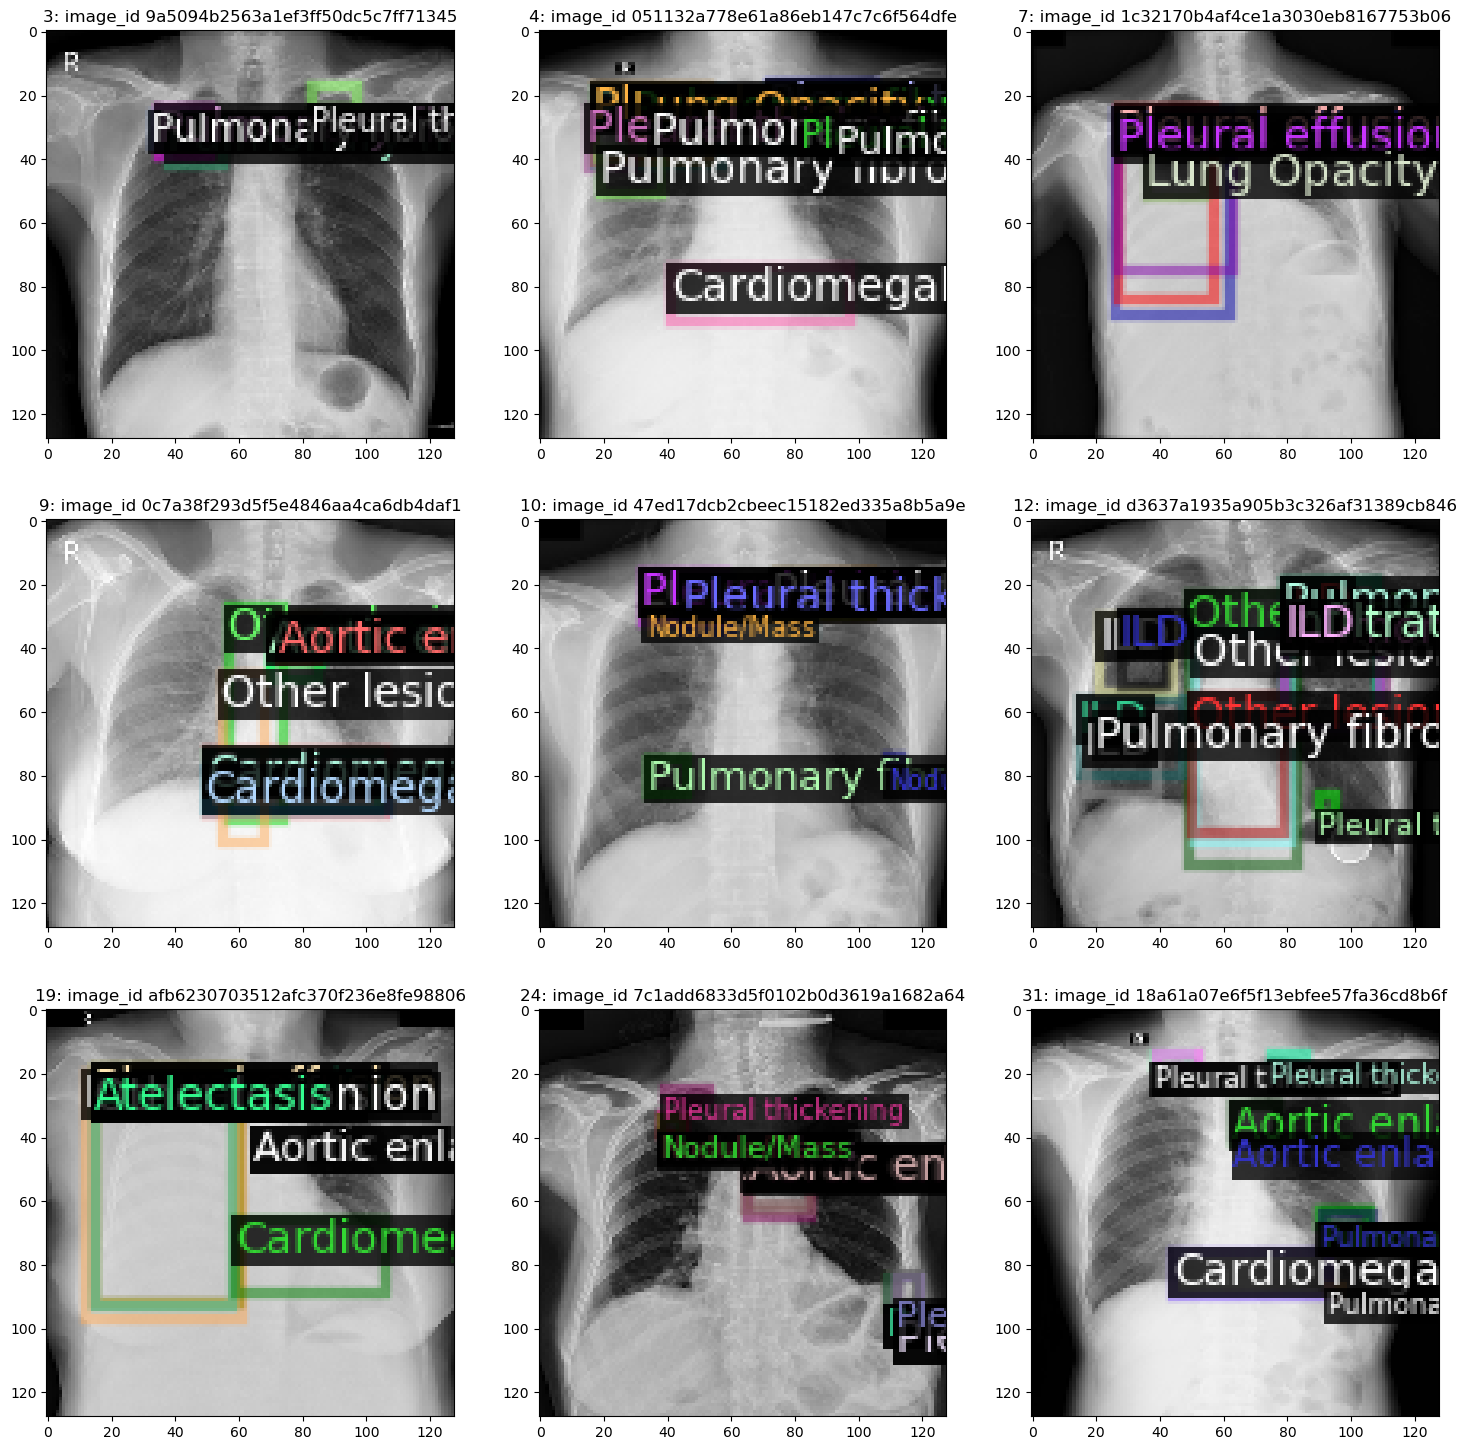

In [30]:
# Visualize data...
anomaly_image_ids = train.query("class_id != 14")["image_id"].unique()
train_meta = pd.read_csv(imgdir/"train_meta.csv")
anomaly_inds = np.argwhere(train_meta["image_id"].isin(anomaly_image_ids).values)[:, 0]

data_metadata = MetadataCatalog.get("data_train")

cols = 3
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for index, anom_ind in enumerate(anomaly_inds[:cols * rows]):
    ax = axes[index]
    # print(anom_ind)
    d = dataset_dicts[anom_ind]
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=data_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # cv2_imshow(out.get_image()[:, :, ::-1])
    #cv2.imwrite(str(outdir / f"data{index}.jpg"), out.get_image()[:, :, ::-1])
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.set_title(f"{anom_ind}: image_id {anomaly_image_ids[index]}")

<a id="training"></a>
# Training

In [31]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("data_train",)
if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("data_valid",)
    cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


cfg.OUTPUT_DIR ./output -> results


In [32]:
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/07 20:04:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (15, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (56, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (56,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[05/07 20:04:51 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\advai\anaconda3\envs\detectron2_env\Lib\site-packages\torch\functional.py:507: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)



[05/07 20:05:03 d2.utils.events]:  eta: 0:32:27  iter: 19  total_loss: 5.2  loss_cls: 2.792  loss_box_reg: 0.04392  loss_rpn_cls: 2.066  loss_rpn_loc: 0.1679    time: 0.1959  last_time: 0.1997  data_time: 0.3432  last_data_time: 0.0011   lr: 1.9516e-05  max_mem: 705M
[05/07 20:05:11 d2.utils.events]:  eta: 0:32:03  iter: 39  total_loss: 2.702  loss_cls: 2.024  loss_box_reg: 0.08539  loss_rpn_cls: 0.4921  loss_rpn_loc: 0.1777    time: 0.1976  last_time: 0.1809  data_time: 0.0013  last_data_time: 0.0012   lr: 3.9007e-05  max_mem: 705M
[05/07 20:05:15 d2.utils.events]:  eta: 0:31:33  iter: 59  total_loss: 1.412  loss_cls: 0.6627  loss_box_reg: 0.1082  loss_rpn_cls: 0.4419  loss_rpn_loc: 0.1417    time: 0.1932  last_time: 0.1825  data_time: 0.0012  last_data_time: 0.0013   lr: 5.8497e-05  max_mem: 705M
[05/07 20:05:18 d2.utils.events]:  eta: 0:31:07  iter: 79  total_loss: 0.9695  loss_cls: 0.2404  loss_box_reg: 0.07024  loss_rpn_cls: 0.4664  loss_rpn_loc: 0.1901    time: 0.1905  last_time:

It's actually very easy to use multiple gpus for training.

You just need to wrap above training scripts by `main` method and use `launch` method provided by `detectron2`.

Please refer official example [train_net.py](https://github.com/facebookresearch/detectron2/blob/master/tools/train_net.py#L161) for details.

<a id="vis_loss"></a>
# Visualize loss curve & competition metric AP40

The calculated metrics are saved in `metrics.json`.

In [33]:
metrics_df = pd.read_json(outdir / "metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss,bbox/AP,bbox/AP-Aortic enlargement,bbox/AP-Atelectasis,bbox/AP-Calcification,bbox/AP-Cardiomegaly,bbox/AP-Consolidation,bbox/AP-ILD,bbox/AP-Infiltration,bbox/AP-Lung Opacity,bbox/AP-Nodule/Mass,bbox/AP-Other lesion,bbox/AP-Pleural effusion,bbox/AP-Pleural thickening,bbox/AP-Pneumothorax,bbox/AP-Pulmonary fibrosis,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.001299,2128.078813,0.002930,0.000000,0.025677,19,0.019976,2.881583,2.101628,0.240937,1.951604e-05,0.001299,502.25,9.75,214.25,41.75,0.213234,5.241946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,0.001338,2008.648652,0.189941,0.268812,0.000000,19,0.032439,2.568721,1.683371,0.135450,1.951604e-05,0.001338,500.00,12.00,224.75,31.25,0.201267,4.528477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,0.001272,2005.138187,0.056641,0.000000,0.000000,19,0.042293,2.556212,2.121276,0.183159,1.951604e-05,0.001272,497.25,14.75,210.75,45.25,0.200916,4.970690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1504,0.001497,3464.380354,0.008301,0.000000,0.012195,19,0.052817,2.780633,1.943476,0.207911,1.951604e-05,0.001497,496.25,15.75,213.00,43.00,0.347132,5.039008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1654,0.001146,1947.646401,0.003418,0.000000,0.047619,19,0.043922,2.792322,2.066278,0.167927,1.951604e-05,0.001146,497.50,14.50,213.75,42.25,0.195155,5.200409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,0.001530,0.000000,0.986328,0.380952,0.534884,9999,0.154191,0.183575,0.111926,0.094064,2.467401e-11,0.001530,512.00,0.00,256.00,0.00,0.193854,0.672317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284916
500,NaN,NaN,NaN,NaN,NaN,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.701772,17.774629,2.658048,0.489501,20.886808,9.631630,9.565336,10.466368,7.346870,2.452756,1.180778,14.336489,2.977723,0.0,8.057873,14.315006,18.310495,15.018291,10.949737,4.273641,NaN
1503,NaN,NaN,NaN,NaN,NaN,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.854575,17.712879,2.345148,0.686979,20.099645,9.069426,9.470662,10.796924,7.919862,3.007168,1.717461,15.465151,3.053312,0.0,8.619429,14.696654,18.571651,13.482723,11.214853,4.584813,NaN
1001,NaN,NaN,NaN,NaN,NaN,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.736518,17.445236,2.958741,1.147922,20.812014,8.837095,8.372792,11.210898,7.085471,3.181657,1.278931,14.559674,3.161471,0.0,8.259358,14.217461,18.475551,13.184506,11.138983,4.652186,NaN


In [34]:
metrics_df.mean(axis = 0) 

data_time                        0.001314
eta_seconds                   1041.028644
fast_rcnn/cls_accuracy           0.944573
fast_rcnn/false_negative         0.510738
fast_rcnn/fg_cls_accuracy        0.440245
iteration                     4772.329002
loss_box_reg                     0.193687
loss_cls                         0.205994
loss_rpn_cls                     0.142653
loss_rpn_loc                     0.102522
lr                               0.000471
rank_data_time                   0.001314
roi_head/num_bg_samples        470.796490
roi_head/num_fg_samples         41.203510
rpn/num_neg_anchors            220.457462
rpn/num_pos_anchors             35.542538
time                             0.194142
total_loss                       0.697541
bbox/AP                          6.358180
bbox/AP-Aortic enlargement      16.248709
bbox/AP-Atelectasis              1.393162
bbox/AP-Calcification            0.592968
bbox/AP-Cardiomegaly            18.518803
bbox/AP-Consolidation            6

In [35]:
mdf.to_csv(outdir / 'detectron2_results.csv')

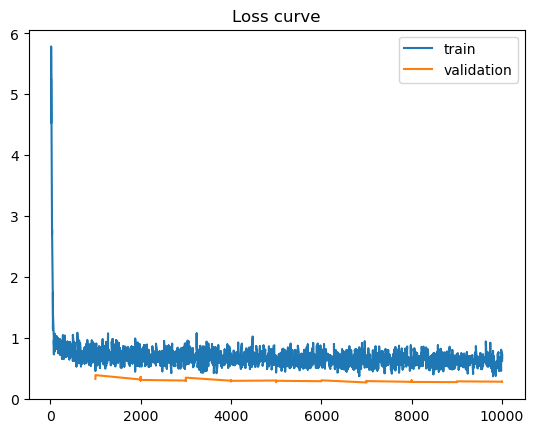

<Figure size 640x480 with 0 Axes>

In [36]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()
plt.savefig(outdir/"loss.png")

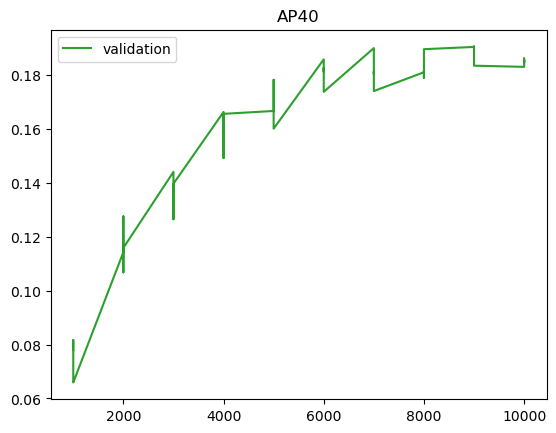

<Figure size 640x480 with 0 Axes>

In [37]:
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["bbox/AP75"].isna()]
ax.plot(mdf3["iteration"], mdf3["bbox/AP75"] / 100., c="C2", label="validation")

ax.legend()
ax.set_title("AP40")
plt.show()
plt.savefig(outdir / "AP40.png")

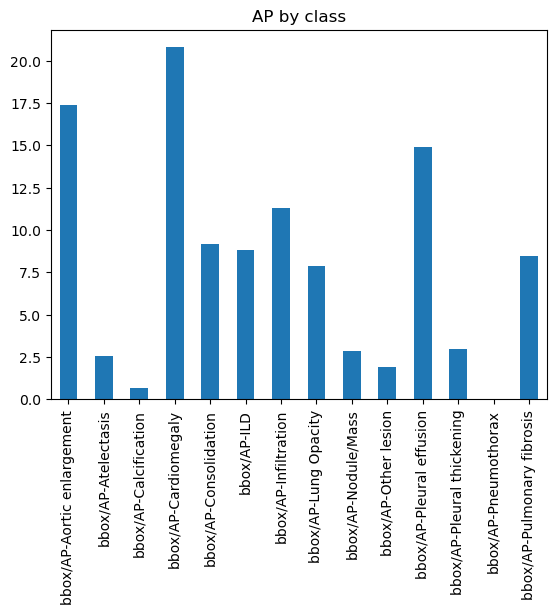

In [38]:
fig, ax = plt.subplots()
mdf_bbox_class = mdf3.iloc[-1][[f"bbox/AP-{col}" for col in thing_classes]]
mdf_bbox_class.plot(kind="bar", ax=ax)
_ = ax.set_title("AP by class")

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=0.0, mask_value=0.0, rotate_method='largest_box'),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={}, is_check_shapes=True)
Load from cache dataset_dicts_cache_original_14class0_debug0.pkl
[05/07 21:44:59 d2.data.build]: Removed 8505 images with no usable annotations. 3495 images left.
[05/07 21:44:59 d2.data.common]: Serializing the data

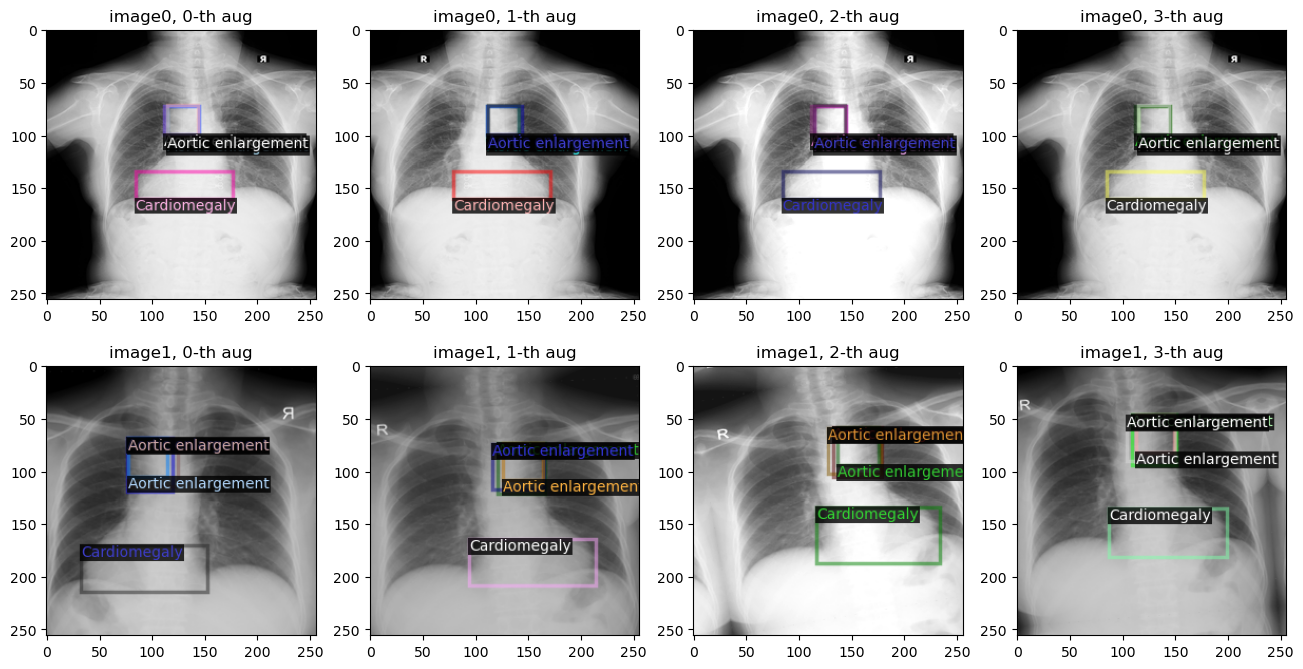

In [39]:
# Visualize data...
# import matplotlib.pyplot as plt
from detectron2.data.samplers import TrainingSampler

n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=data_metadata, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                data_metadata.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"data_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break

In [40]:
#  !zip -r detectron2_results.zip ./

## Prediction Scripts

In [41]:
# Methods for prediction for this competition
from math import ceil
from typing import Any, Dict, List

import cv2
import detectron2
import numpy as np
from numpy import ndarray
import pandas as pd
import torch
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode, Visualizer
from tqdm import tqdm


def format_pred(labels: ndarray, boxes: ndarray, scores: ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)


def predict_batch(predictor: DefaultPredictor, im_list: List[ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

In [42]:
inputdir = Path("input")
traineddir = "results/"

# flags = Flags()
flags: Flags = Flags().update(load_yaml(traineddir+"/flags.yaml"))
print("flags", flags)
debug = flags.debug
# flags_dict = dataclasses.asdict(flags)
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)

# --- Read data ---
datadir = inputdir / "data-dicom-format"
if flags.imgdir_name == "data-resized-256x256":
    imgdir = inputdir/ "data-resized-256x256"
else:
    imgdir = inputdir / flags.imgdir_name

# Read in the data CSV files
# train = pd.read_csv(datadir / "train.csv")
test_meta = pd.read_csv(inputdir / "data-resized-256x256" / "test_meta.csv")
sample_submission = pd.read_csv(datadir / "sample_submission.csv")

flags Flags(debug=False, outdir='results', imgdir_name='data-resized-256x256', split_mode='valid20', seed=111, train_data_type='original', use_class14=False, iter=10000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupCosineLR', base_lr=0.001, roi_batch_size_per_image=512, eval_period=1000, aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'ShiftScaleRotate': {'p': 0.5, 'rotate_limit': 10, 'scale_limit': 0.15}})


In [43]:
cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ()
# cfg.DATASETS.TEST = ("data_train",)
# cfg.TEST.EVAL_PERIOD = 50
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

### --- Inference & Evaluation ---
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
# path to the model we just trained
cfg.MODEL.WEIGHTS = str(traineddir+"/model_final.pth")
print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # set a custom testing threshold
print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
predictor = DefaultPredictor(cfg)

DatasetCatalog.register(
    "data_test", lambda: get_data_dicts_test(imgdir, test_meta, debug=debug)
)
MetadataCatalog.get("data_test").set(thing_classes=thing_classes)
metadata = MetadataCatalog.get("data_test")
dataset_dicts = get_data_dicts_test(imgdir, test_meta, debug=debug)

if debug:
    dataset_dicts = dataset_dicts[:100]

results_list = []
index = 0
batch_size = 4

for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
        if index < 5:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.5,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # cv2_imshow(out.get_image()[:, :, ::-1])
            cv2.imwrite(str(outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])

        image_id, dim0, dim1 = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 14 1 0 0 1 1x.
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()

            result = {
                "image_id": image_id,
                "PredictionString": format_pred(
                    pred_classes_array, pred_boxes_array, pred_scores_array
                ),
            }
        results_list.append(result)
        index += 1

cfg.OUTPUT_DIR ./output -> results
Original thresh 0.05
Changed  thresh 0.0
[05/07 21:45:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from results//model_final.pth ...
Load from cache dataset_dicts_cache_test_debug0.pkl


100%|██████████| 750/750 [03:34<00:00,  3.49it/s]


In [44]:
# This submission includes only detection model's predictions
submission_det = pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])
submission_det.to_csv(outdir/"submission.csv", index=False)
submission_det

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,0 0.8027157187461853 1029 606 1252 872 11 0.25...
1,287422bed1d9d153387361889619abed,3 0.9330746531486511 669 1044 1883 1910 0 0.87...
2,1d12b94b7acbeadef7d7700b50aa90d4,0 0.8948593735694885 1188 894 1426 1160 3 0.71...
3,6b872791e23742f6c33a08fc24f77365,0 0.41801774501800537 1041 899 1256 1145 13 0....
4,d0d2addff91ad7beb1d92126ff74d621,0 0.9641162753105164 1455 846 1717 1147 3 0.82...
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,0 0.8297216892242432 1026 772 1210 980 3 0.196...
2996,afee8ff90f29b8827d0eb78774d25324,0 0.5122313499450684 1025 714 1242 959 11 0.27...
2997,6e07fab2014be723250f7897ab6e3df2,0 0.9818867444992065 1626 803 1957 1145 3 0.88...
2998,690bb572300ef08bbbb7ebf4196099cf,0 0.42564478516578674 1091 693 1335 935 5 0.12...


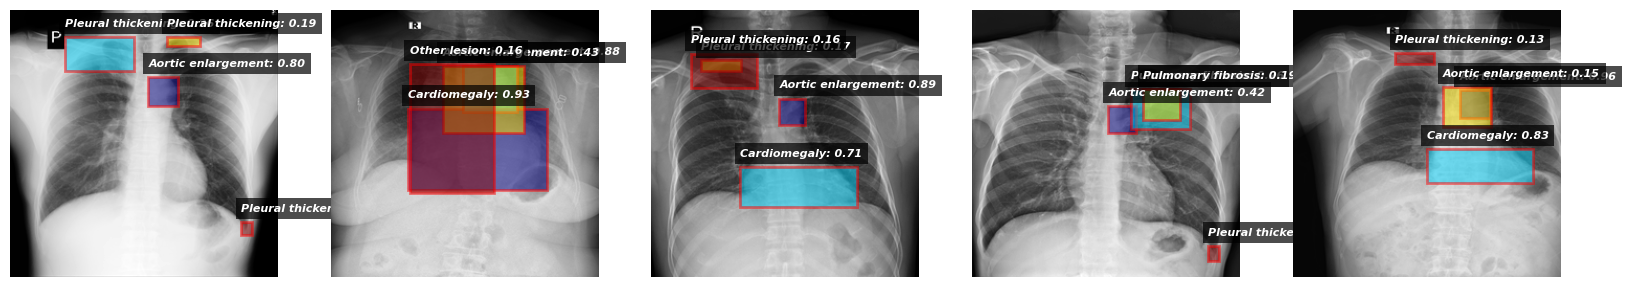

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np  # For generating unique colors

# Function to split prediction strings into a DataFrame
def expand_pred_string(pred_string):
    data = []
    for item in pred_string.split():
        data.append(float(item))
    return pd.DataFrame(data=np.array(data).reshape(-1, 6), columns=['class_id', 'confidence', 'x_min', 'y_min', 'x_max', 'y_max'])

# Function to plot an image with bounding boxes, showing only the top 4 predictions
def plot_image_bboxes_top4(image_id, ax, predictions_df, test_meta, thing_classes):
    # Retrieve original dimensions from test_meta
    original_dim = test_meta.loc[test_meta['image_id'] == image_id, ['dim0', 'dim1']].values[0]
    target_dim = (256, 256)  # The resized dimensions

    image_path = f"input/data-resized-256x256/test/{image_id}.png"
    image = Image.open(image_path)
    ax.imshow(image, cmap='gray')

    # Scale factors for x and y dimensions
    y_scale = target_dim[0] / original_dim[0]
    x_scale = target_dim[1] / original_dim[1]

    # Sort predictions by confidence and select the top 4
    predictions_df = predictions_df.sort_values(by='confidence', ascending=False).head(4)

    # Generate unique colors for each box
    colors = plt.cm.jet(np.linspace(0, 1, len(predictions_df)))

    for i, (index, row) in enumerate(predictions_df.iterrows()):
        # Apply scale to bounding box coordinates
        x = row['x_min'] * x_scale
        y = row['y_min'] * y_scale
        width = (row['x_max'] - row['x_min']) * x_scale
        height = (row['y_max'] - row['y_min']) * y_scale
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor=colors[i], alpha=0.5)
        ax.add_patch(rect)
        label = f"{thing_classes[int(row['class_id'])]}: {row['confidence']:.2f}"
        ax.text(x, y - 10, label, color='white', fontsize=8, weight='bold', style='italic',
                bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))
    ax.axis('off')

# Load metadata
test_meta = pd.read_csv('input/data-resized-256x256/test_meta.csv')

# Assuming submission_det is loaded and thing_classes defined
num_samples = 5  # Number of samples to display
fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))

for i, (index, row) in enumerate(submission_det.head(num_samples).iterrows()):
    pred_df = expand_pred_string(row['PredictionString'])
    plot_image_bboxes_top4(row['image_id'], axs[i], pred_df, test_meta, thing_classes)

plt.show()

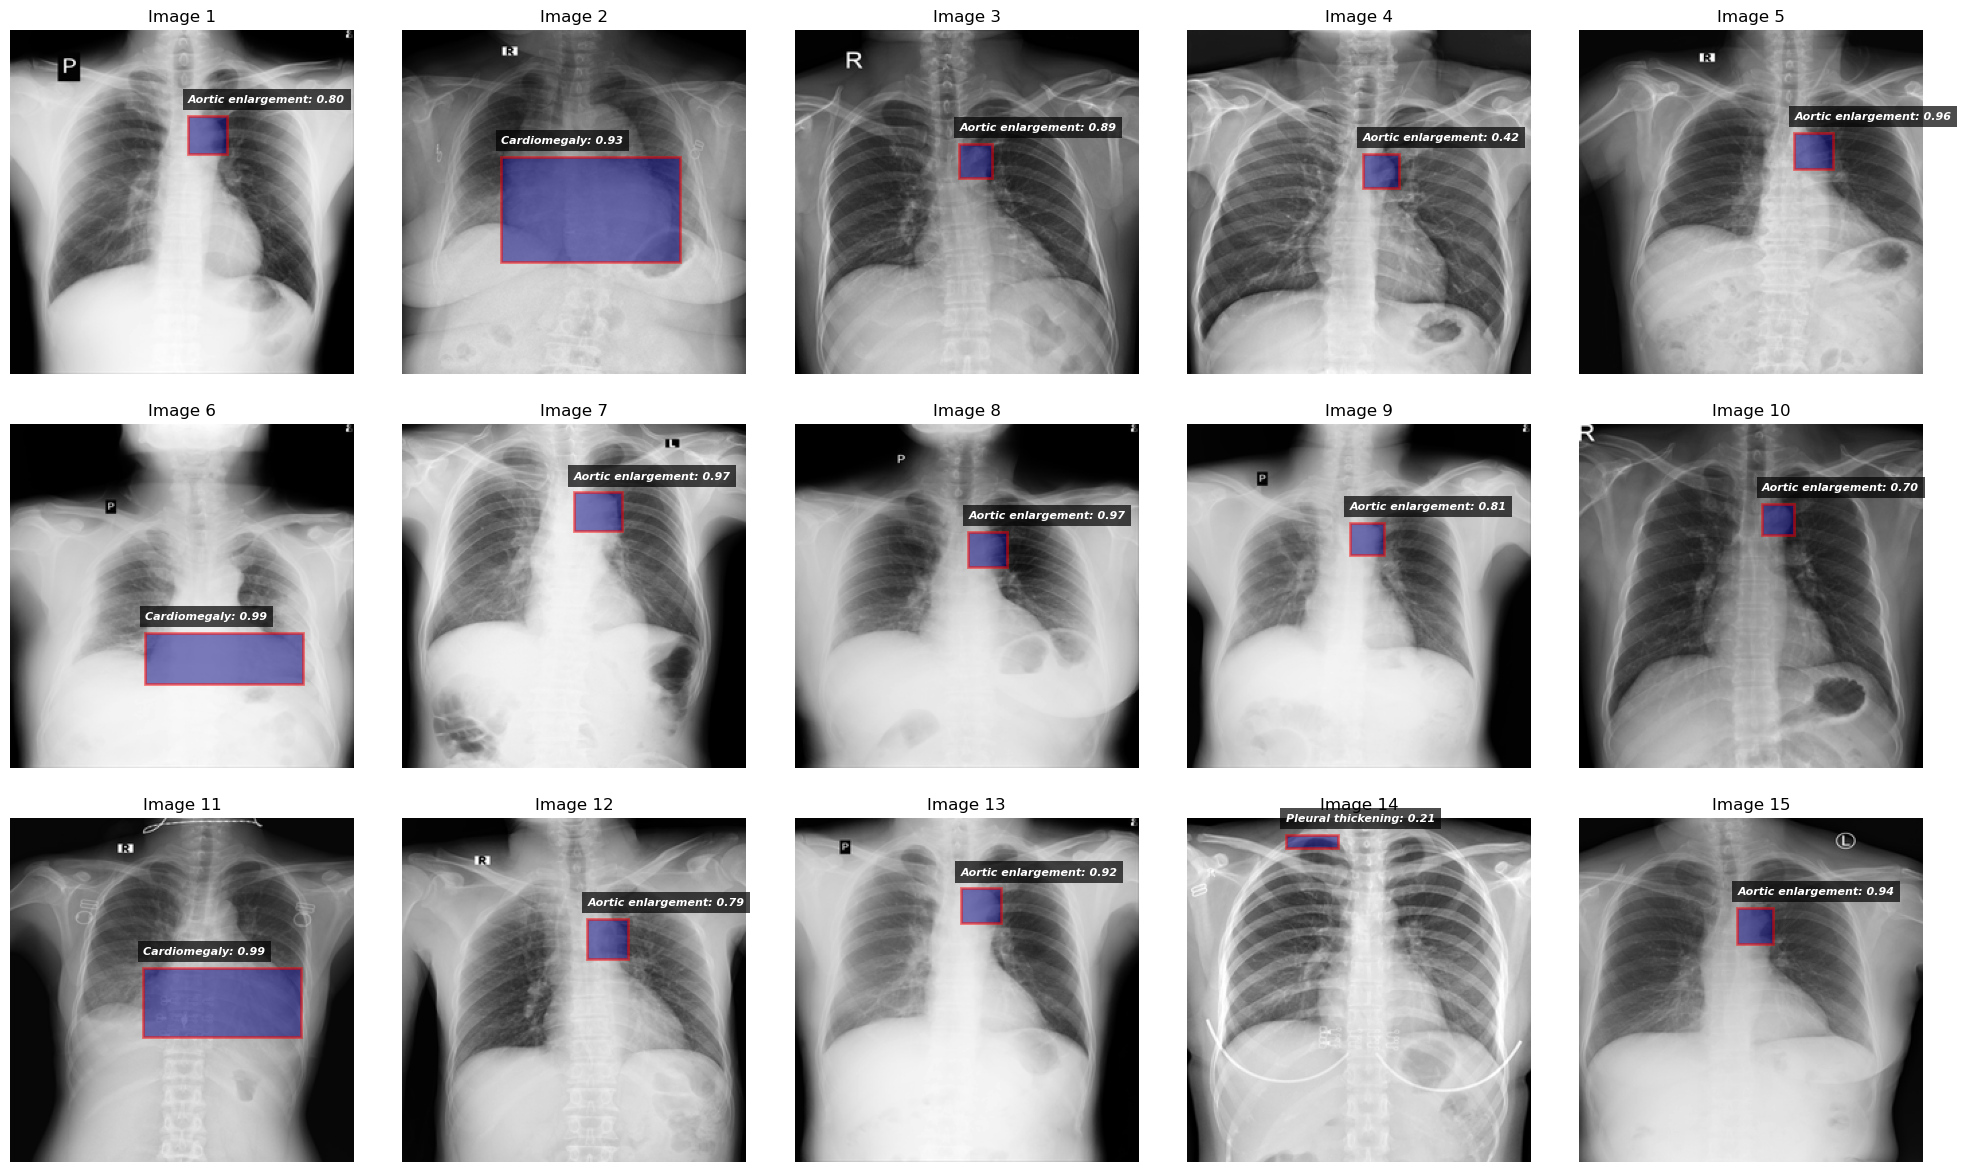

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import pandas as pd
import numpy as np  # For generating unique colors
import math


# Function to split prediction strings into a DataFrame
def expand_pred_string(pred_string):
    data = []
    for item in pred_string.split():
        data.append(float(item))
    return pd.DataFrame(data=np.array(data).reshape(-1, 6), columns=['class_id', 'confidence', 'x_min', 'y_min', 'x_max', 'y_max'])

# Function to plot an image with bounding boxes, showing only the top 4 predictions
def plot_image_bboxes_top4(image_id, ax, predictions_df, test_meta, thing_classes):
    # Retrieve original dimensions from test_meta
    original_dim = test_meta.loc[test_meta['image_id'] == image_id, ['dim0', 'dim1']].values[0]
    target_dim = (256, 256)  # The resized dimensions

    image_path = f"input/data-resized-256x256/test/{image_id}.png"
    image = Image.open(image_path)
    ax.imshow(image, cmap='gray')

    # Scale factors for x and y dimensions
    y_scale = target_dim[0] / original_dim[0]
    x_scale = target_dim[1] / original_dim[1]

    # Sort predictions by confidence and select the top 4
    predictions_df = predictions_df.sort_values(by='confidence', ascending=False).head(1)

    # Generate unique colors for each box
    colors = plt.cm.jet(np.linspace(0, 1, len(predictions_df)))

    for i, (index, row) in enumerate(predictions_df.iterrows()):
        # Apply scale to bounding box coordinates
        x = row['x_min'] * x_scale
        y = row['y_min'] * y_scale
        width = (row['x_max'] - row['x_min']) * x_scale
        height = (row['y_max'] - row['y_min']) * y_scale
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor=colors[i], alpha=0.5)
        ax.add_patch(rect)
        label = f"{thing_classes[int(row['class_id'])]}: {row['confidence']:.2f}"
        ax.text(x, y - 10, label, color='white', fontsize=8, weight='bold', style='italic',
                bbox=dict(facecolor='black', alpha=0.7, edgecolor='none'))
    ax.axis('off')

# Load metadata
test_meta = pd.read_csv('input/data-resized-256x256/test_meta.csv')

# Assuming submission_det is loaded and thing_classes defined
num_samples = 15  # Total number of images you want to display
num_cols = 5  # Number of images per row
num_rows = math.ceil(num_samples / num_cols)  # Calculate the number of rows needed

# Create a figure with subplots in a grid of num_rows x num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))  # Adjust the size as needed

# Flatten the array of axes (subplots)
axs = axs.ravel()

for i, (index, row) in enumerate(submission_det.iterrows()):
    if i >= num_samples:
        break  # Break the loop if the number of samples is exceeded
    pred_df = expand_pred_string(row['PredictionString'])
    plot_image_bboxes_top4(row['image_id'], axs[i], pred_df, test_meta, thing_classes)
    axs[i].set_title(f"Image {i+1}")  # Optional: Add a title to each subplot

# If the total number of images is not a perfect multiple of the number of columns, turn off the remaining axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()